In [1]:
import os
import polars as pl

df = pl.read_csv("./features_cleaned.csv")

from sklearn.preprocessing import StandardScaler

print(df)
scaler = StandardScaler()
name_df = df.clone()
df = df.select(
    pl.exclude("name")
)
df = pl.DataFrame(scaler.fit_transform(df))
data = df.to_numpy()
print(df)
print(df.std())
print(df.mean())

# weight
# df = df.with_columns(
#     column_74 = pl.col("column_74") * 3,
#     column_75 = pl.col("column_75") * 3,
# )

print(df)
print(df.std())
print(df.mean())


shape: (91, 77)
┌──────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬────────────┬───────────────┐
│ f1_min   ┆ f1_max   ┆ f1_std   ┆ f1_mean  ┆ … ┆ f19_max  ┆ f19_std  ┆ f19_mean   ┆ name          │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---        ┆ ---           │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64        ┆ str           │
╞══════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪════════════╪═══════════════╡
│ 0.799281 ┆ 1.007484 ┆ 0.073116 ┆ 0.932172 ┆ … ┆ 0.001576 ┆ 0.000177 ┆ 1.8636e-8  ┆ dance_data_60 │
│          ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆ _corrected    │
│ 0.992883 ┆ 0.997509 ┆ 0.001072 ┆ 0.994284 ┆ … ┆ 0.000068 ┆ 0.000011 ┆ -1.8950e-7 ┆ dance_data_75 │
│          ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆ _corrected    │
│ 0.860762 ┆ 0.988121 ┆ 0.038375 ┆ 0.944305 ┆ … ┆ 0.00117  ┆ 0.000213 ┆ -5.

[[3.80000000e+01 4.40000000e+01 1.63921065e-01 2.00000000e+00]
 [1.00000000e+00 9.10000000e+01 1.80820601e-01 3.00000000e+00]
 [2.70000000e+01 9.20000000e+01 2.20877641e-01 4.00000000e+00]
 [2.90000000e+01 9.30000000e+01 4.03742956e-01 5.00000000e+00]
 [4.00000000e+00 2.30000000e+01 4.06251090e-01 2.00000000e+00]
 [9.40000000e+01 9.50000000e+01 9.63035136e-01 7.00000000e+00]
 [2.00000000e+01 4.60000000e+01 1.52974035e+00 2.00000000e+00]
 [3.30000000e+01 3.70000000e+01 1.57688096e+00 2.00000000e+00]
 [8.30000000e+01 8.90000000e+01 1.82424647e+00 2.00000000e+00]
 [2.10000000e+01 2.80000000e+01 2.14303719e+00 2.00000000e+00]
 [4.70000000e+01 6.30000000e+01 2.21886027e+00 2.00000000e+00]
 [7.30000000e+01 7.60000000e+01 2.41055302e+00 2.00000000e+00]
 [8.20000000e+01 9.90000000e+01 2.76413171e+00 3.00000000e+00]
 [5.80000000e+01 6.60000000e+01 2.80766261e+00 2.00000000e+00]
 [3.20000000e+01 9.80000000e+01 2.97302989e+00 3.00000000e+00]
 [5.60000000e+01 1.02000000e+02 3.28612761e+00 3.000000

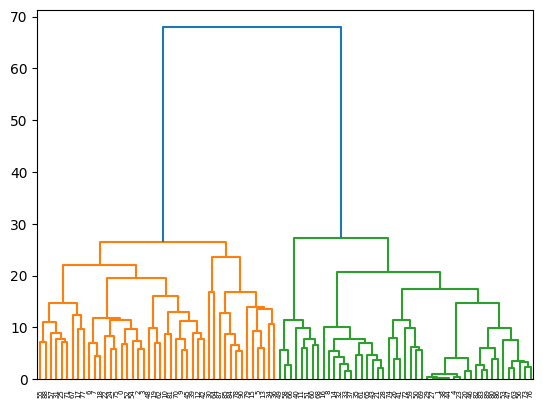

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# display with scipy
linkage_data = linkage(data, method='ward', metric='euclidean')
dendrogram(linkage_data)
print(linkage_data)
plt.show()

[(0, 'dance_data_5_corrected'), (1, 'dance_data_10_corrected'), (2, 'dance_data_30_corrected'), (3, 'dance_data_41_corrected'), (4, 'dance_data_45_corrected'), (5, 'dance_data_29_corrected')]


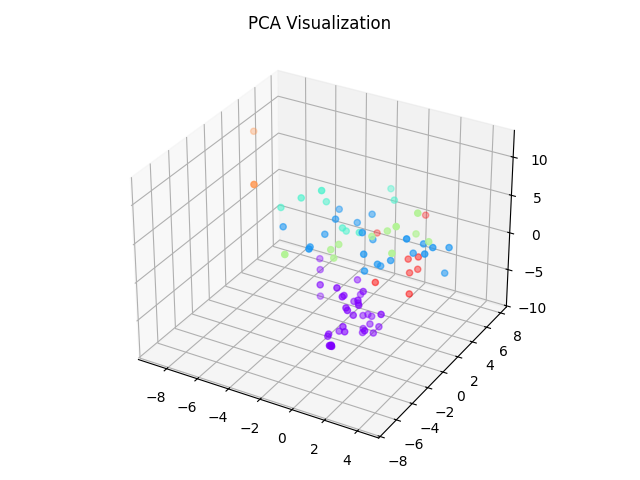

In [3]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

n=8
hierarchical_cluster = AgglomerativeClustering(n_clusters=n, linkage='ward')
labels = hierarchical_cluster.fit_predict(data)
cluster_dict = {"cluster": labels}
out_df = name_df.hstack(pl.from_dict(cluster_dict))
out_df = out_df.select(
    pl.col("name"),
    pl.col("cluster"),
).sort(pl.col("cluster"), pl.col("name"))
out_df.write_csv(f"stat-hierarchial-{n}n.csv")

combined_df = name_df.join(
    out_df,
    on=["name"],
    how="inner"
)

cluster_centers = []
clusters = pl.from_dict(cluster_dict)["cluster"].unique().to_list()
for cluster in clusters:
    cluster_df = combined_df.filter(
        pl.col("cluster") == cluster
    ).drop(
        pl.col("cluster")
    )
    cluster_means = cluster_df.drop("name").mean().to_numpy()
    cluster_min, cluster_min_name = np.Infinity, ""
    for row in cluster_df.rows():
        name = row[-1]
        row_data = row[:-1]
        row_np = np.array(row_data)
        diff = cluster_means - row_np
        dmean = diff.mean()
        if dmean < cluster_min:
            cluster_min_name = name
            cluster_min = dmean
    cluster_centers.append((cluster, cluster_min_name))
print(cluster_centers)

from sklearn.decomposition import PCA

n_components = 3
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(data) 
names = name_df["name"].to_list()

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_pca[:, 2], X_pca[:, 1], X_pca[:, 0], c=labels, cmap=plt.cm.rainbow)

plt.title("PCA Visualization")
plt.tight_layout()
plt.show()